# Denoising Image with AutoEncoder in PyTorch

In [1]:
import torch 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
from tqdm.notebook import tqdm 

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Exploring Dataset 

In [3]:
data = pd.read_csv("data/mnist_dataset.csv")
data.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
image = data.iloc[7] # selecting image at index 7 
image = np.array(image).astype('float32')
image = np.reshape(image,(28,28)) # reshaping image to 28 x 28 
image = image / 255 # to scale image between 0 to 1

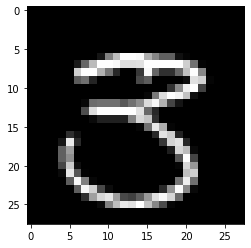

In [5]:
plt.imshow(image,cmap = "gray") 

In [6]:
noisy_image = image + 0.2 * np.random.randn(*image.shape) # Adding random noise to image 
noisy_image = np.clip(noisy_image,0,1) #ranging between 0 - 1

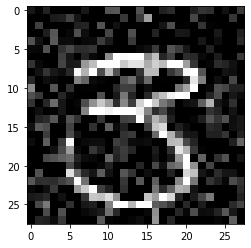

In [7]:
plt.imshow(noisy_image,cmap = "gray")

# Data Preparation 

In [4]:
from torch.utils.data import Dataset
from helper import show_image, ToTensorForAE

In [5]:
class MNIST_AE_Dataset(Dataset):
    
    def __init__(self,csv_file,noise_factor = 0.2,transform = None):
        
        self.data = pd.read_csv(csv_file)
        self.transform = transform 
        self.noise_factor = noise_factor
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        
        img = self.data.iloc[idx]
        img = np.array(img)
        img = np.reshape(img,(28,28,1)) / 255
        
        noisy_img = img + self.noise_factor * np.random.randn(*img.shape)
        noisy_img = np.clip(noisy_img,0.,1.)
        
        sample = (noisy_img,img)
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample

In [6]:
trainset = MNIST_AE_Dataset('data/mnist_dataset.csv',transform = ToTensorForAE())

In [7]:
print("Size of trainset : {}".format(len(trainset)))

Size of trainset : 42000


In [8]:
noisy_image,org_image = trainset[6]
noisy_image.shape

torch.Size([1, 28, 28])

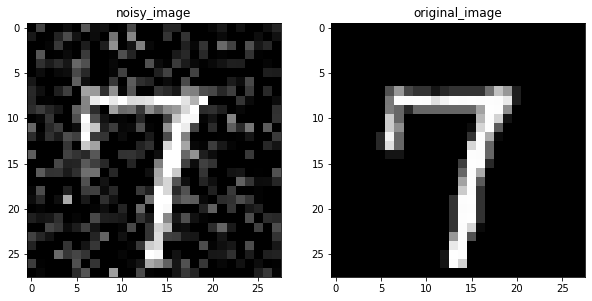

In [9]:
show_image(noisy_image,org_image) 

# Load dataset into batches

In [14]:
from torch.utils.data import DataLoader 

In [15]:
trainloader = DataLoader(trainset,batch_size = 16,shuffle = True)

In [16]:
dataiter = iter(trainloader)
noisy_image, org_image = dataiter.next()

print("Shape of loading one batch : {}".format(noisy_image.shape))
print("Shape of loading one batch : {}".format(org_image.shape))

print("Total no. of batches present in trainloader : {}".format(len(trainloader))) #total no. of batches
print("Total no. of examples present in trainloader : {}".format(len(trainloader.dataset)))

Shape of loading one batch : torch.Size([16, 1, 28, 28])
Shape of loading one batch : torch.Size([16, 1, 28, 28])
Total no. of batches present in trainloader : 2625
Total no. of examples present in trainloader : 42000


# Create AutoEncoder Model

In [19]:
import torch
from torch import nn 
from torchsummary import summary

In [20]:
def Encoder():
    
    enc = nn.Sequential(
        
        nn.Conv2d(in_channels = 1, out_channels = 16,kernel_size = (3,3),padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = (2,2)), 
        nn.Conv2d(in_channels = 16, out_channels = 32,kernel_size = (3,3),padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = (2,2))
    )
    
    return enc

In [21]:
def Decoder():
    
    dec = nn.Sequential(
        
        nn.ConvTranspose2d(in_channels = 32,out_channels = 16,kernel_size = (2,2),stride = 2),
        nn.ReLU(),
        nn.ConvTranspose2d(in_channels = 16,out_channels = 1,kernel_size = (2,2),stride = 2),
        nn.Sigmoid()
    )
    
    return dec

In [25]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
       
        
        self.encoder = Encoder()
        self.decoder = Decoder()


    def forward(self, x):
       
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = ConvAutoencoder()
if torch.cuda.is_available():
    model.cuda()
model

ConvAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
    (3): Sigmoid()
  )
)

In [26]:
summary(model,input_size = (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]           4,640
              ReLU-5           [-1, 32, 14, 14]               0
         MaxPool2d-6             [-1, 32, 7, 7]               0
   ConvTranspose2d-7           [-1, 16, 14, 14]           2,064
              ReLU-8           [-1, 16, 14, 14]               0
   ConvTranspose2d-9            [-1, 1, 28, 28]              65
          Sigmoid-10            [-1, 1, 28, 28]               0
Total params: 6,929
Trainable params: 6,929
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.38
Params size (MB): 0.03
Estimated Total

# Train AutoEncoder Model 

In [27]:
from torch import optim
from tqdm import tqdm 

In [28]:
optimizer = optim.Adam(model.parameters(),lr = 0.001)
criterion = nn.MSELoss()
epochs = 5

In [30]:
for i in range(epochs):
    
    train_loss = 0.0
    
    for noisy_image,image in tqdm(trainloader):
        noisy_image, image = noisy_image.to(device), image.to(device)
        
        optimizer.zero_grad()
        pred_image = model(noisy_image)
        loss = criterion(pred_image,image)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
    print("Epoch : {} Train Loss : {}".format(i+1,train_loss/len(trainloader)))

  0%|          | 12/2625 [00:00<00:21, 119.21it/s]

Epoch : 1 Train Loss : 0.019434636512150365


  0%|          | 12/2625 [00:00<00:22, 118.04it/s]

Epoch : 2 Train Loss : 0.00577454994406019


  0%|          | 13/2625 [00:00<00:21, 124.06it/s]

Epoch : 3 Train Loss : 0.005219981576715197


  0%|          | 13/2625 [00:00<00:20, 125.91it/s]

Epoch : 4 Train Loss : 0.0049460423196710296


100%|██████████| 2625/2625 [00:20<00:00, 127.74it/s]

Epoch : 5 Train Loss : 0.004782326509466484


# Plot Results

torch.Size([1, 28, 28])


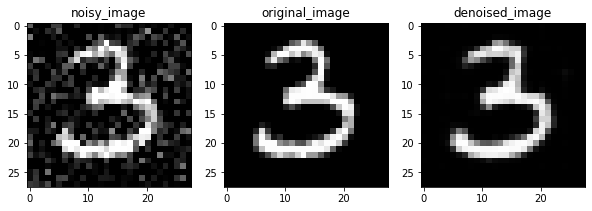

In [36]:
model.eval()

with torch.no_grad():
    
    dataiter = iter(trainloader)
    sample = dataiter.next()
    
    noisy_image,image = sample
    
    index = 5
    
    pred_image = model(noisy_image[index].to(device).unsqueeze(0))
    print(pred_image.squeeze(0).shape)
    show_image(noisy_image[index], image[index], pred_image.to(torch.device("cpu")).squeeze(0))